In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
from scipy import stats

from Bio import SeqIO
import urllib.request
import os

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# define variables
additives = ['PA','phthalate','DBP','TP']
dic_additives = dict(zip(additives,[x+'*' for x in additives]))
dic_additives

blast_eval_cutoff = 1e-10
cut_in = list(range(60,91,5))
cut_in

palett = sns.color_palette("Paired")

(95, 8)


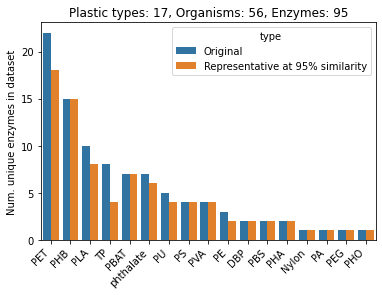

(82, 6)
(82, 6)


In [3]:
# Input data to representative seqs for blast

# load and plot cdhit results
df = pd.read_csv('../data/Dataset_queries.csv',sep=',')
print(df.shape)
df_in = df

tmp = []
for record in SeqIO.parse('../data/all_enzymes_uniprot-0.95', "fasta"):
    tmp.append([record.description,''.join(record.seq)])

df_in_70 = pd.DataFrame(tmp,columns=['other','aa_seq'])
tmp = df_in_70.other.str.split('%',expand=True)
tmp.columns = ['plastic','id','proteins names','organism']
df_in_70 = pd.concat([tmp,df_in_70],axis=1).drop(columns=['other'])

# plot both at once
df_in['type'] = 'Original'
df_in_70['type'] = 'Representative at 95% similarity'

# plot
sns.barplot(data=(pd
                  .concat([df_in_70,df_in])
                  .groupby('type')
                  .plastic.value_counts()
                  .rename('counts')
                  .reset_index()
                 ),
            y='counts',x='plastic',hue='type')
plt.xticks(rotation=45,ha='right')
plt.xlabel('')
plt.ylabel('Num. unique enzymes in dataset')
plt.title('Plastic types: '+str(df_in.plastic.unique().shape[0])+', '
          'Organisms: '+str(df_in.organism.unique().shape[0])+', '
          'Enzymes: '+str(df_in.aa_seq.unique().shape[0]))
plt.show()

print(df_in_70.shape)
print(df_in_70.drop_duplicates().shape)

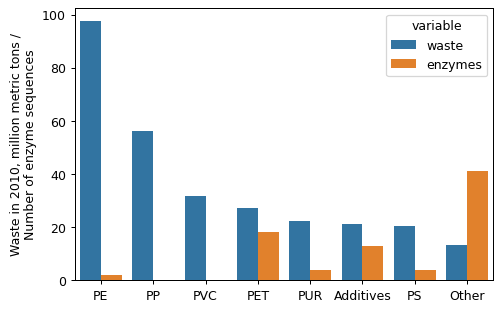

In [4]:
# Plot data production waste vs initial data to see coverage

# load pollution data
df_waste = pd.read_excel('../data/2017_Roland_figS4_data.xlsx') 
tmp = df_waste.iloc[1].iloc[1:11].tolist()
tmp[0] = tmp[0].replace('\xa0','')
cols = ['year']
cols.extend(tmp)
cols
df_waste = df_waste.iloc[2:,:11].reset_index(drop=True)
df_waste.columns=cols
# merge LDPE HDPE
df_waste['PE'] = df_waste['LD,LDPE']+df_waste['HDPE']

df_waste = (df_waste
 .drop(columns=['LD,LDPE','HDPE'])
 .set_index('year')
 .stack()
 .reset_index()
 .rename(columns={'level_1':'group',0:'waste'})
)

# fix headers
rename = pd.DataFrame(df_in_70.plastic.unique(),columns=['plastic'])
rename
rename['group'] = ['Other',
                   'PUR',
                   'Other',
                   'Additives',
                   'Additives',
                   'Other',
                   'PET',
                   'Other',
                   'Other',
                   'Other',
                   'Other',
                   'Additives',
                   'Additives',
                   'Other',
                   'PE',
                   'Other',
                   'PS']
rename

# plot   
df_plot = (df_waste[(df_waste.year==2010)&
                    (df_waste.group!='PP&A')]
         .merge(df_in_70
        .merge(rename,on='plastic',how='left')
        .groupby('group')
        .id.count()
        .rename('enzymes')
        .reset_index(),on='group',how='left')
        .melt(id_vars='group',value_vars=['waste','enzymes'])
          )
        
mpl.rcParams['figure.dpi'] = 90
sns.barplot(data=df_plot,
            x='group',y='value',
            hue='variable',
            order=(df_waste[df_waste.group!='PP&A']
                   .sort_values(by='waste',ascending=False)
                   .group
                   .unique()
                   .tolist()),
           #palette=['k','r']1b
           )
plt.ylabel('Waste in 2010, million metric tons /\nNumber of enzyme sequences')
plt.xlabel('')
plt.show()

In [5]:
# Analysis of blast results and hits files for hmms

# Load data
colnames = ["qseqid",
            "sseqid",
           "pident",
           "length",
           "mismatch",         
           "gapopen",
           "qstart",
           "qend",
           "sstart",
           "send",
           "evalue",
           "bitscore"]

df_blast = pd.read_csv('../data/all_enzymes_uniprot-0.95_vs_uniprot_trembl.blast',sep='\t',names=colnames)
df_blast['qid'] = (df_blast
     .qseqid
     .apply(lambda x: x.split('%')[1])
    ) 
df_blast = (df_blast[(df_blast.pident<100)& # remove self similarities
                     (df_blast.pident>50)&
                     (df_blast
                     .qid
                     .isin(df.id))]
            .merge(df[['id','plastic']],left_on='qid',
                   right_on='id',how='left')
            .query('evalue<=@blast_eval_cutoff')
           )
print(df_blast.shape)
df_blast.head()

(16834, 15)


,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qid,id,plastic
0,PHB%Q9ZNH8%PHB,tr|A0A1F4EKU9|A0A1F4EKU9_9BURK,98.982,491,5,0,1,491,1,491,0.0,988.0,Q9ZNH8,Q9ZNH8,PHB
1,PHB%Q9ZNH8%PHB,tr|A0A1F4J9G6|A0A1F4J9G6_9BURK,98.574,491,7,0,1,491,1,491,0.0,984.0,Q9ZNH8,Q9ZNH8,PHB
2,PHB%Q9ZNH8%PHB,tr|A0A3D1MJX1|A0A3D1MJX1_9BURK,98.371,491,8,0,1,491,1,491,0.0,983.0,Q9ZNH8,Q9ZNH8,PHB
3,PHB%Q9ZNH8%PHB,tr|A0A1F4GL39|A0A1F4GL39_9BURK,98.371,491,8,0,1,491,1,491,0.0,983.0,Q9ZNH8,Q9ZNH8,PHB
4,PHB%Q9ZNH8%PHB,tr|A0A495HTG7|A0A495HTG7_9BURK,98.167,491,9,0,1,491,1,491,0.0,982.0,Q9ZNH8,Q9ZNH8,PHB


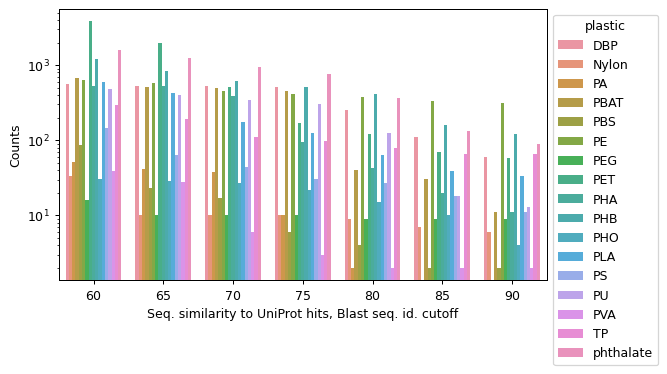

In [6]:
plt.figure(figsize=(7,4))
tmp = []
for c in cut_in:
    tmp.append(df_blast[df_blast.pident>c]
               .groupby('plastic')
               .pident
               .count()
               .reset_index())
    tmp[-1]['cutoff'] = c

sns.barplot(data=pd.concat(tmp),x='cutoff',
            y='pident',hue='plastic')
plt.legend(bbox_to_anchor=(1,1),title='plastic')
plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('Seq. similarity to UniProt hits, Blast seq. id. cutoff')
plt.show()

(498, 5)
(75,)
mkdir: cannot create directory ‘output_files’: File exists


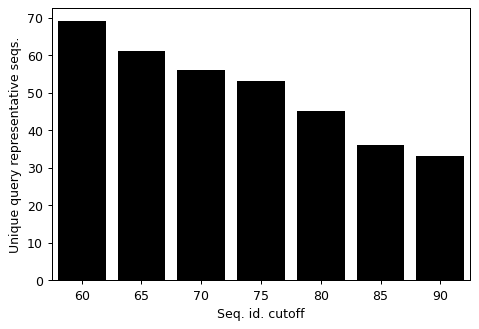

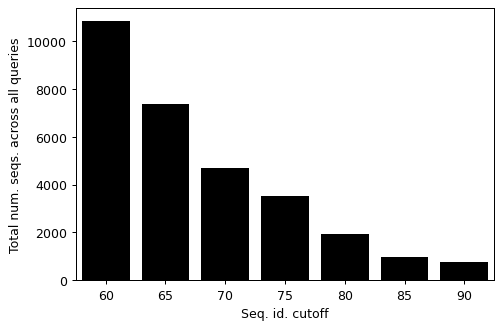

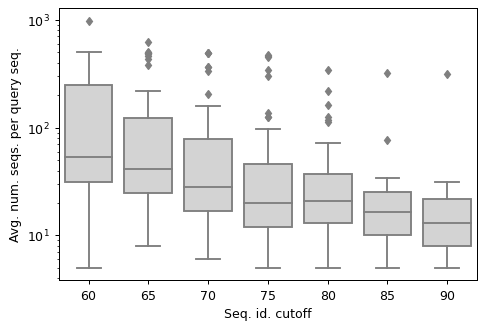

In [7]:
# plot hits for hmms for whole range of tresholds

tmp = []
for c in [60,65,70,75,80,85,90,95]:
    tmp.append(df_blast[df_blast.pident>c]
               #.groupby('plastic')
               .groupby('qid')
               .sseqid
               .apply(list)
               .reset_index())
    tmp[-1]['cutoff'] = c
    
tmp = pd.concat(tmp)
tmp['num_sseqid'] = tmp.sseqid.apply(len)
tmp['qid_cut'] = tmp.apply(lambda x: x.qid+'_'+str(x.cutoff),axis=1)
print(tmp.shape)
print(tmp.qid.unique().shape)

# save data for building hmms
!mkdir {'output_files'}
fpart = 'output_files/all_enzymes_uniprot-0.95_vs_uniprot_trembl'
for idx,row in tmp.iterrows():
    with open(fpart+'-'+row.qid+'-gt'+str(row.cutoff), 'w') as f: #row.plastic
        for item in row.sseqid:
            f.write("%s\n" % item)

# drop all below treshold for plotting
num_seqs_cutoff = 5
tmp = tmp[tmp.num_sseqid >= num_seqs_cutoff]

# plot descriptive
sns.barplot(data=tmp.query('cutoff.isin(@cut_in)')
            .groupby(['cutoff']).qid.nunique().reset_index(),
            x='cutoff',y='qid',
            color='k') # total seqs
plt.ylabel('Unique query representative seqs.')
plt.xlabel('Seq. id. cutoff')
plt.show()

sns.barplot(data=tmp.query('cutoff.isin(@cut_in)')
            .groupby(['cutoff']).num_sseqid.sum().reset_index(),
            x='cutoff',y='num_sseqid',
            color='k') # total seqs
plt.ylabel('Total num. seqs. across all queries')
plt.xlabel('Seq. id. cutoff')
plt.show()

sns.boxplot(data=tmp.query('cutoff.isin(@cut_in)'),
            x='cutoff',y='num_sseqid',
           color='lightgrey')
plt.ylabel('Avg. num. seqs. per query seq.')
plt.xlabel('Seq. id. cutoff')
plt.yscale('log')
plt.show()

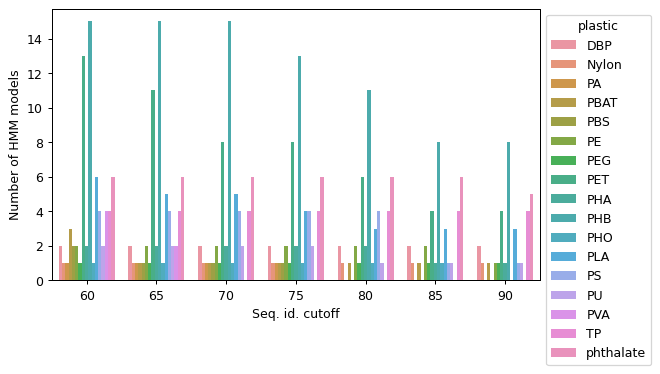

In [8]:
# Plot num HMM models per cutoff per plastic

plt.figure(figsize=(7,4))
sns.barplot(data=(tmp.query('cutoff.isin(@cut_in)')
               .merge(df_in_70[['id','plastic']],left_on='qid',
                      right_on='id',how='left')
               .groupby(['cutoff','plastic'])
               .qid.nunique()
               .reset_index()
              ),
            x='cutoff',y='qid',
            hue='plastic')
plt.ylabel('Number of HMM models')
plt.xlabel('Seq. id. cutoff')
plt.legend(bbox_to_anchor=(1,1),title='plastic')
plt.show()

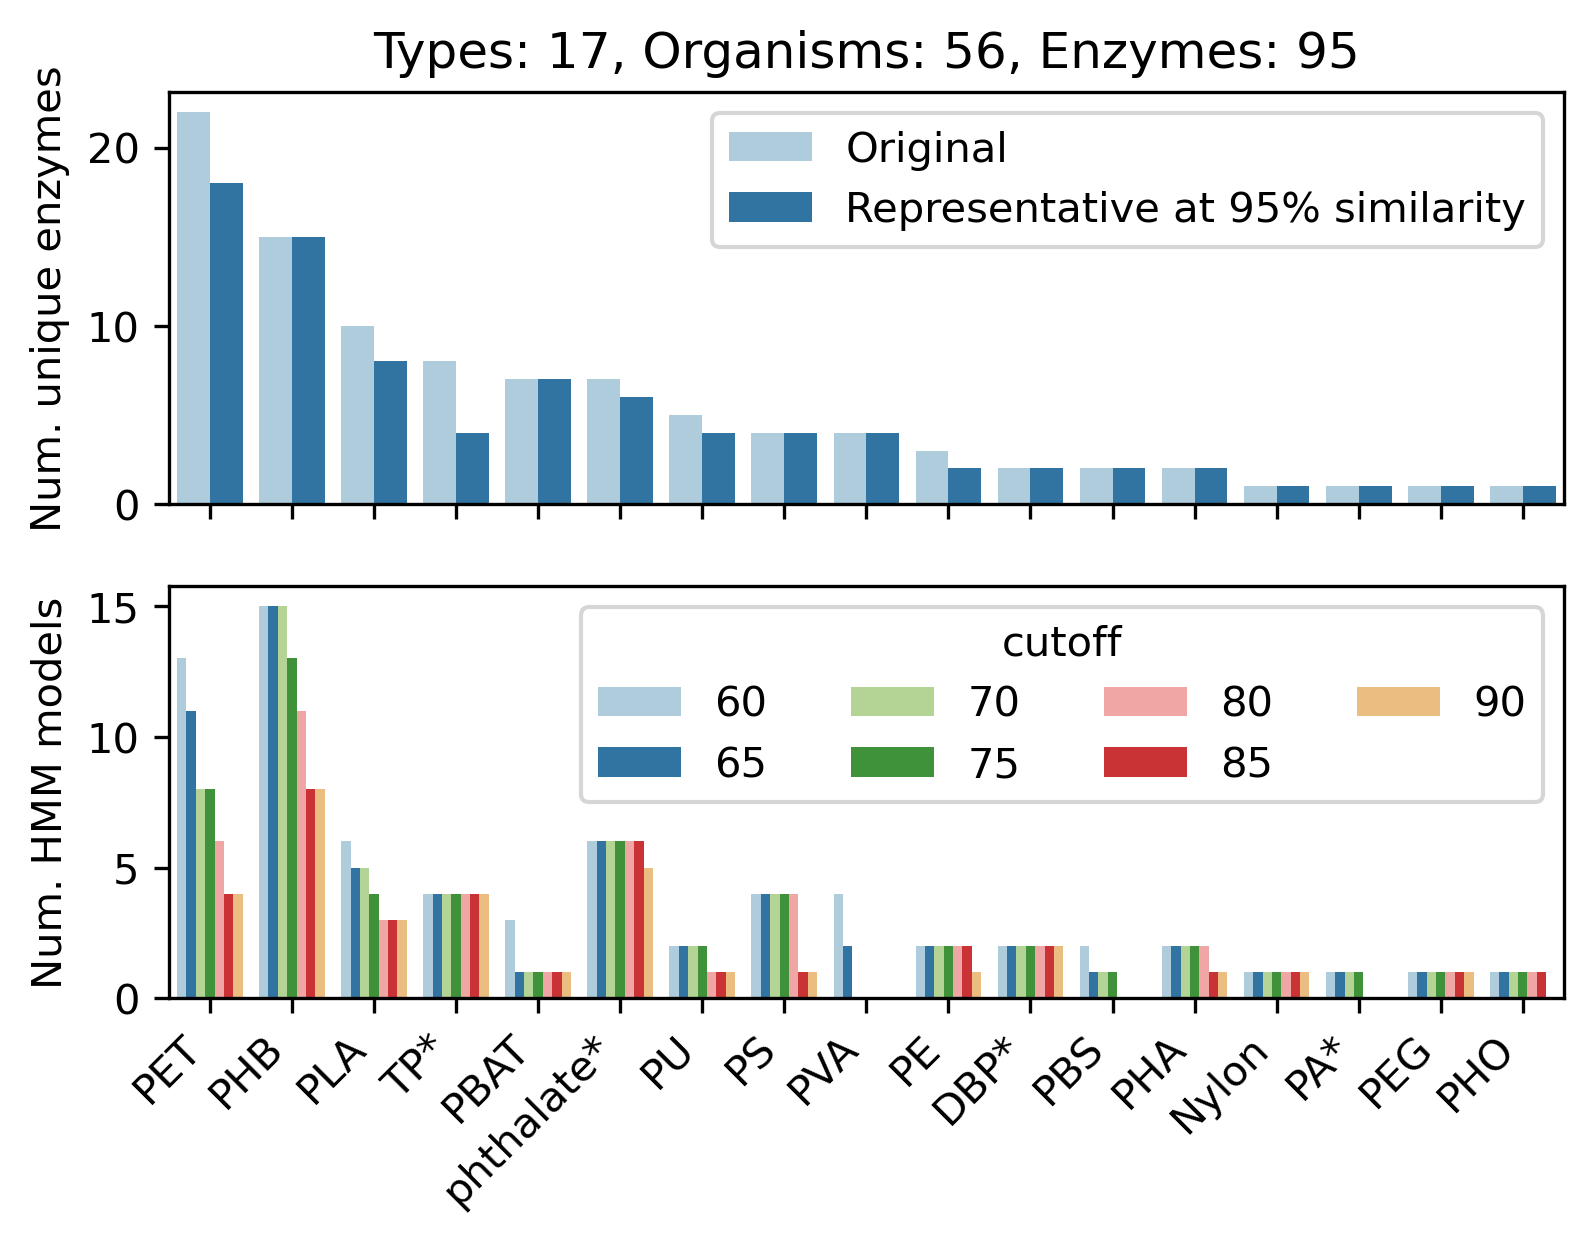

In [9]:
# Stacked plot input data and hmm models

mpl.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(6,4))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212) #, sharex = ax1)

data = (pd
                  .concat([df_in_70,df_in])
                  .groupby('type')
                  .plastic.value_counts()
                  .rename('counts')
                  .reset_index()
                  .replace({'plastic':dic_additives})
                 )
sns.barplot(data=data,
            y='counts',x='plastic',hue='type',
            palette=palett, 
            ax = ax1)

sns.barplot(data=(tmp.query('cutoff.isin(@cut_in)')
               .merge(df_in_70[['id','plastic']],left_on='qid',
                      right_on='id',how='left')
               .groupby(['plastic','cutoff'])
               .qid
               .nunique()
               .reset_index()
               .replace({'plastic':dic_additives})
              ),
            x='plastic',y='qid',hue='cutoff',
            palette=palett,
            order=data.plastic.unique(),
            ax = ax2)

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Num. unique enzymes')
ax2.set_ylabel('Num. HMM models')
ax2.legend(ncol=4,title='cutoff',loc=1)
ax1.legend()

plt.xticks(rotation=45,ha='right')

ax1.set_title('Types: '+str(df_in.plastic.unique().shape[0])+', '
          'Organisms: '+str(df_in.organism.unique().shape[0])+', '
          'Enzymes: '+str(df_in.aa_seq.unique().shape[0]))

plt.show()